# Wrapping Libraries - Bagle Example

This notebook is part of a series demonstrating how users can add support for their own simulation packages by adding simple wrappers. The example covered in this notebook is the [Bagle Microlensing package](https://github.com/MovingUniverseLab/bagle_microlensing). To run this notebook you will need to install Bagle. See the instructions [here](https://bagle.readthedocs.io/en/latest/installation.html).

This notebook is based on the [lightcurvelynx_BAGLE.ipynb notebook](https://github.com/LSST-TVSSC/microlensing/blob/main/lightcurvelynx_simulations/lightcurvelynx_BAGLE.ipynb) by Natasha Abrams and Katarzyna Kruszynska (2025).


## Bagle

[Bagel](https://github.com/MovingUniverseLab/bagle_microlensing) is a package for simulating and analyzing gravitational lensing effects, which includes functions to model the output of such event. For an introduction to bagle, see their tutorial notebook: [https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb](https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb).

Bagle uses the `bagle.model` object to store the information and perform the computations for microlensing events. This is the object that we will want to wrap within a LightCurveLynx ``BasePhysicalModel`` so we can use it in the computation flow.

Let's start by looking at how we can create and query a standard bagle model. The object's constructor takes in the parameters as (order dependent) arguments. For example, we can create a `PSPL_PhotAstrom_Par_Param1` (point source, point lens) object as:

In [1]:
from bagle import model

# Create the event model with given parameter.
event1 = model.PSPL_PhotAstrom_Par_Param1(
    1.0,  # mL (msun)
    61600,  # t0 (MJD)
    0.1,  # beta (mas)
    4000.0,  # dL (pc)
    4000.0 / 8000.0,  # dL/dS
    0.0,  # xS0_E (mas/yr)
    0.0,  # xS0_N (mas/yr)
    5.0,  # muL_E (mas/yr)
    10.0,  # muL_N (mas/yr)
    0.0,  # muS_E (mas/yr)
    0.0,  # muS_N (mas/yr)
    [1, 1, 1, 1, 1, 1],  # b_sff
    [23, 22, 21.5, 21, 20.5, 19.5],  # mag_src
    raL=270.66679,  # RA (deg)
    decL=-35.70483,  # Dec (deg)
)

Given the model, we can query for outputs, such as the amplification level, over given times. Here we use 200.0 days before the given t0 to 200.0 days after it.

Text(0, 0.5, 'Amplification')

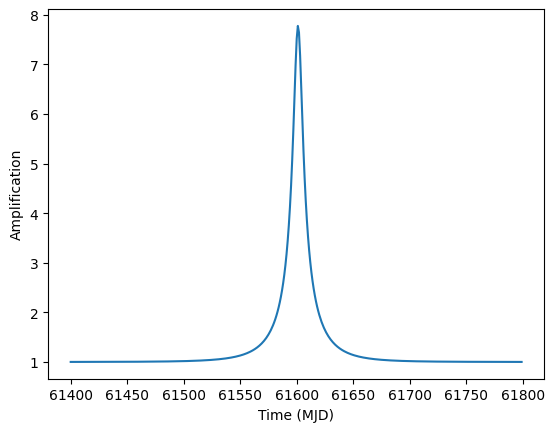

In [2]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(61400.0, 61800.0, 1.0)

A = event1.get_amplification(t)
plt.plot(t, A)
plt.xlabel("Time (MJD)")
plt.ylabel("Amplification")

Most important for our case will be the model’s ``get_photometry()`` function which will return the *magnitudes* for a given filter at a given array of times. We can uses this as the basis for LightCurveLynx’s computation function with a few modifications. Most notably, LightCurveLynx uses fluxes in nJy, so we will need to convert the magnitudes.

## Wrapping Bagle Models

To wrap a bagle model we need to design a subclass of LightCurveLynx's `BasePhysicalModel` that:
1) constructs the bagle model,
2) sets its parameters, and 
3) queries the flux that it produces (returning the results in nJy). 
Since bagle models operate on the bandflux level, we start by subclassing LightCuvreLynx's `BandfluxModel` class.

We start using an alternative approach for creating a model object from the model name (given in Abrams and Kruszynska's notebook) that loads the model from the library (using Python's ``getattr()`` function) and assemble the parameters as a dictionary.

In [ ]:
# Give the name of the class we will create.
model_name = "PSPL_PhotAstrom_Par_Param1"

# Define the parameters as a dictionary.
dL = 4000  # Distance to lens
dS = 8000  # Distance to source
parameter_dict = {
    "raL": 270.66679,
    "decL": -35.70483,
    "mL": 1,  # Msun (Primary lens current mass)
    "t0": 61600,  # mjd
    "beta": 0.1,
    "dL": dL,
    "dL_dS": dL / dS,
    "xS0_E": 0.0,  # arbitrary offset (arcsec)
    "xS0_N": 0.0,  # arbitrary offset (arcsec)
    "muL_E": 5.0,
    "muL_N": 10.0,
    "muS_E": 0.0,
    "muS_N": 0.0,
    "b_sff": [1, 1, 1, 1, 1, 1],
    "mag_src": [23, 22, 21.5, 21, 20.5, 19.5],
}

# Create the model object, by creating the model class by name and
# passing the parameters as a dictionary.
mod_class = getattr(model, model_name)
mod = mod_class(**parameter_dict)

To wrap this as a LightCurveLynx model, we will need two functions:
* ``__init__()`` - Set up the internal data and register the (settable) parameters.
* ``compute_bandflux()`` - Compute the flux values (in nJy) at given times and filters.

The model above specifies the ``b_sff`` and ``mag_src`` for the filters in the order: u, g, r, i, z, y. To make the mappings easier, we also define a class variable `_filter_idx` with dictionary mapping filter name to its index.

In [ ]:
from lightcurvelynx.astro_utils.mag_flux import mag2flux
from lightcurvelynx.models.physical_model import BandfluxModel


class FixedBagelModel(BandfluxModel):
    """A wrapper for a Bagle model with a fixed set of parameters."""

    # Convenience mapping from filter name to index in the parameter list.
    _filter_idx = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}

    def __init__(self, model_name, parameter_dict, **kwargs):
        # We start by extracting the parameter information needed for a general
        # physical model (base class).
        ra = parameter_dict["raL"]
        dec = parameter_dict["decL"]
        t0 = parameter_dict["t0"]

        # Call the parent class constructor to set up the model.
        super().__init__(ra=ra, dec=dec, t0=t0, **kwargs)

        # The create the bagle model object and set the parameters.
        self.model_name = model_name
        self.parameter_dict = parameter_dict
        mod_class = getattr(model, model_name)
        self.model_obj = mod_class(**parameter_dict)

    def compute_bandflux(self, times, filter, state):
        """Evaluate the model at the passband level for a single, given graph state and filter.

        Parameters
        ----------
        times : numpy.ndarray
            A length T array of observer frame timestamps in MJD.
        filter : str
            The name of the filter.
        state : GraphState
            An object mapping graph parameters to their values with num_samples=1.
            This is not used in this model, but is required for the function signature.

        Returns
        -------
        bandflux : numpy.ndarray
            A length T array of band fluxes for this model in this filter.
        """
        mags = self.model_obj.get_photometry(times, self._filter_idx[filter])

        # Convert mags to fluxes.
        bandflux = mag2flux(mags)
        return bandflux


# Create the source object.
source = FixedBagelModel(model_name, parameter_dict)

### The Init Function

The ``__init__()`` function starts by extracting the parameters needed by the base class (RA, dec, and t0). Then it uses the earlier approach to load the class from its name and instantiate the object with the parameter dictionary. This object is saved in the ``model_obj`` attribute for use in computation.


### The Compute Function
  
The ``compute_bandflux()`` simply uses the saved model to compute the bandflux values for the given times and filter. Since bagle models use an integer index for each of the different filters, we use the filter to index map to query the correct part of the model.

Note that the logic here is pretty simple. The bagle library does all the heavy lifting. The compute function only needs to know how to map the inputs into the format bagle is expecting and map the outputs to what LightCurveLynx is expecting.


## Using the Model in a Simulation

Once we define a ``FixedBagelModel``, we can use it in the general LightCurveLynx simulation framework.

First, as always, we load the OpSim and filter information we want to use for the simulation.


In [5]:
from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.obstable.opsim import OpSim

opsim_db = OpSim.from_db(_LIGHTCURVELYNX_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")

table_dir = _LIGHTCURVELYNX_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)

Then we run the simulation, passing the wrapped object as the source we want to simulate.

This is relatively fast because we are only evaluating the bagle model at the points where it is actually observed. In this case that means those times when Rubin's field of view included (270.66679, -35.70483).

In [ ]:
from lightcurvelynx.simulate import simulate_lightcurves

# Peform three simulations of the source given the opsim and passband group.
lightcurves = simulate_lightcurves(source, 3, opsim_db, passband_group)

Simulating: 100%|██████████| 3/3 [00:00<00:00, 156.58obj/s]


We can plot the simulated observations using LightCurveLynx's ``plot_lightcurves`` function.

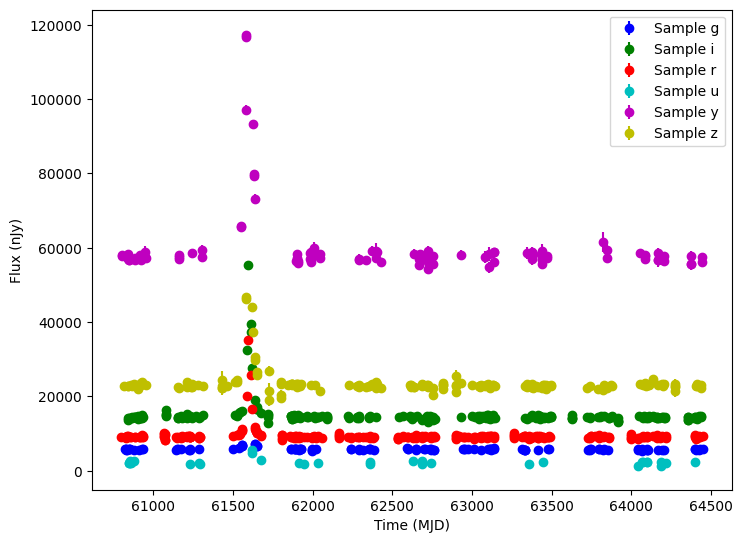

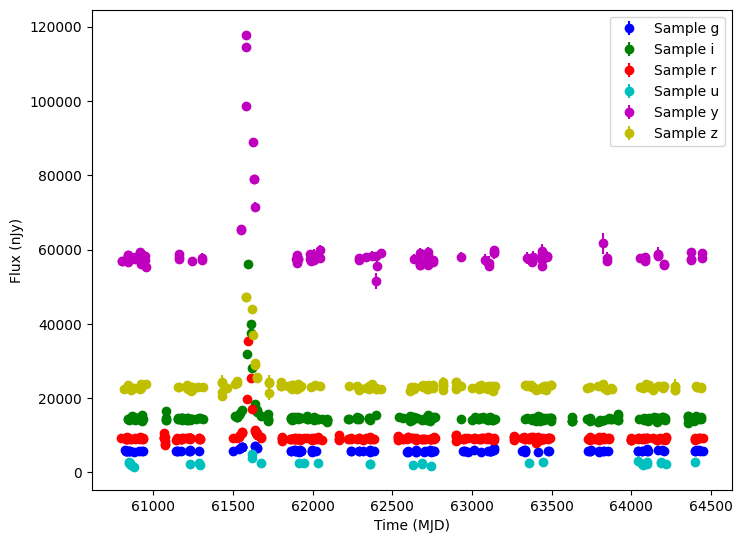

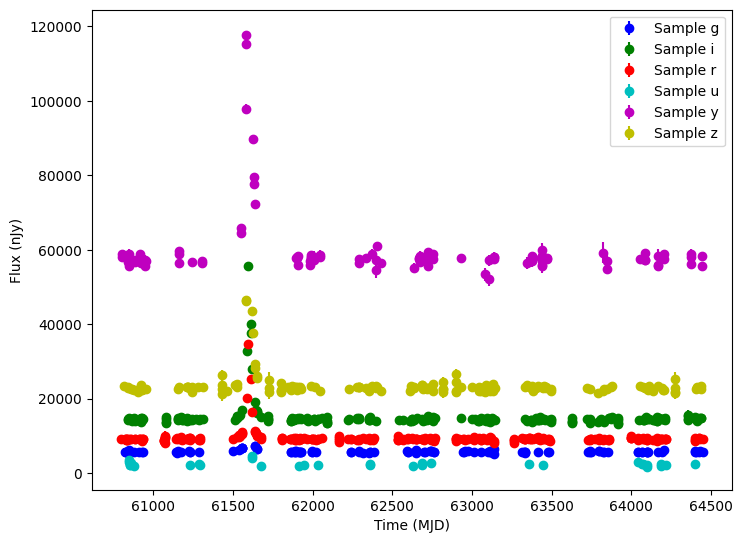

In [7]:
from lightcurvelynx.utils.plotting import plot_lightcurves

for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=np.asarray(lc["lightcurve"]["flux"], dtype=float),
        times=np.asarray(lc["lightcurve"]["mjd"], dtype=float),
        fluxerrs=np.asarray(lc["lightcurve"]["fluxerr"], dtype=float),
        filters=np.asarray(lc["lightcurve"]["filter"], dtype=str),
    )
    ax.legend()
    plt.show()

The **good news** is that the microlensing event shows up where expected (t0=61600). Unfortunately the **bad news** is that all three simulated events are identical, because we created the model using a fixed set of parameters. We just simulated the same microlensing event three times.

## Adding LightCurveLynx Dynamic Sampling

We can make the LightCurveLynx wrapper more powerful by allowing the parameters to be set by the package’s sampling framework. As shown in other tutorial notebooks, parameters of a LightCurveLynx model can be set from a variety of sources, including constants or parameters from other nodes. In order to support a dynamic parameter, we use the ``add_parameter()`` function to add it to the model object. It will then be incorporated into the sampling flow.

Let's start by modifying our model wrapper class to register and use each of the bagle model's parameter. Since they are passed as a dictionary, we can iterate over the items in the dictionary.

In [ ]:
class BagelModel(BandfluxModel):
    """A wrapper for a Bagle model with a flexible set of parameters."""

    # Convenience mapping from filter name to index in the parameter list.
    _filter_idx = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}

    def __init__(self, model_name, parameter_dict, **kwargs):
        # We start by extracting the parameter information needed for a general physical model.
        ra = parameter_dict["raL"]
        dec = parameter_dict["decL"]
        t0 = parameter_dict["t0"]

        # Call the parent class constructor to set up the model.
        super().__init__(ra=ra, dec=dec, t0=t0, **kwargs)

        # Add all of the parameters in the dictionary as settable parameters (if they are not
        # already set by the parent class) and save their names (in order) for later use.
        self.parameter_names = []
        for param_name, param_value in parameter_dict.items():
            self.parameter_names.append(param_name)
            if param_name not in self.list_params():
                self.add_parameter(param_name, param_value)

        # Save the model name and class, but DO NOT create the model object yet.
        self.model_name = model_name
        self.model_class = getattr(model, model_name)

    def compute_bandflux(self, times, filter, state):
        """Evaluate the model at the passband level for a single, given graph state and filter.

        Parameters
        ----------
        times : numpy.ndarray
            A length T array of observer frame timestamps in MJD.
        filter : str
            The name of the filter.
        state : GraphState
            An object mapping graph parameters to their values with num_samples=1.
            This is not used in this model, but is required for the function signature.

        Returns
        -------
        bandflux : numpy.ndarray
            A length T array of band fluxes for this model in this filter.
        """
        # Extract the local parameters for this object from the full state object.
        local_params = self.get_local_params(state)

        # Create the bagle model object and set the parameters from the current state. We do this
        # here because the parameters saved in `state` will be different in each run.
        current_params = {param_name: local_params[param_name] for param_name in self.parameter_names}
        model_obj = self.model_class(**current_params)

        # Use the newly created model object with the current parameters to compute the photometry.
        mags = model_obj.get_photometry(times, self._filter_idx[filter])
        bandflux = mag2flux(mags)
        return bandflux

### The Init Function

The ``__init__()`` function is similar to the earlier example. It starts by extracting the parameters needed by the base class (RA, dec, and t0) and calling that class’s constructor. Then it iterates through the given dictionary saving a list of all the keys and adding any unknown parameters to the model. Note that we need to check whether a parameter already exists because the ``t0`` parameter will be added by the base class’s constructor.

Unlike the previous implementation, this constructor does not create the object. As we will see next, this is because we need to create a new object for each set of parameters we have sampled.


### The Compute Function
  
The ``compute_bandflux()`` extracts the sampled parameters from the ``state`` object and constructs a dictionary from them. The ``state`` object holds all the sampled parameter data for each run of the simulation, allowing users to replay all or part of the simulation. These objects are created when sampling the model’s parameters and their values filled in according to the recipes that define each parameter.

Once the function has constructed the dictionary object, it instantiates a new instance of the bagle model and uses it to generate the fluxes. While this might seem wasteful (we only use the object once), it is necessary because we need each of the objects to have different sets of parameters.

### Modifying the Simulation

To use the newly supported settable parameters, let's expand out the parameter dictionary so that three of the parameters are randomly chosen:

* ``mL`` will be sampled uniformly from [1,10) solar masses.
* ``t0`` will be sampled uniformly from [61000, 63000)
* ``beta`` be sampled from a normal distribution with mean=0.6 and std=0.1.

In [ ]:
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc

dL = 4000  # Distance to lens
dS = 8000  # Distance to source
parameter_dict2 = {
    "raL": 270.66679,
    "decL": -35.70483,
    "mL": NumpyRandomFunc("uniform", low=1, high=20),
    "t0": NumpyRandomFunc("uniform", low=61000, high=63000),
    "beta": NumpyRandomFunc("normal", loc=0.6, scale=0.1),
    "dL": dL,
    "dL_dS": dL / dS,
    "xS0_E": 0.0,  # arbitrary offset (arcsec)
    "xS0_N": 0.0,  # arbitrary offset (arcsec)
    "muL_E": 5.0,
    "muL_N": 10.0,
    "muS_E": 0.0,
    "muS_N": 0.0,
    "b_sff": [1, 1, 1, 1, 1, 1],
    "mag_src": [23, 22, 21.5, 21, 20.5, 19.5],
}

# Create the source object.
source2 = BagelModel(model_name, parameter_dict2)

Once again, we sample and simulate the new objects.

Simulating: 100%|██████████| 5/5 [00:00<00:00, 145.43obj/s]


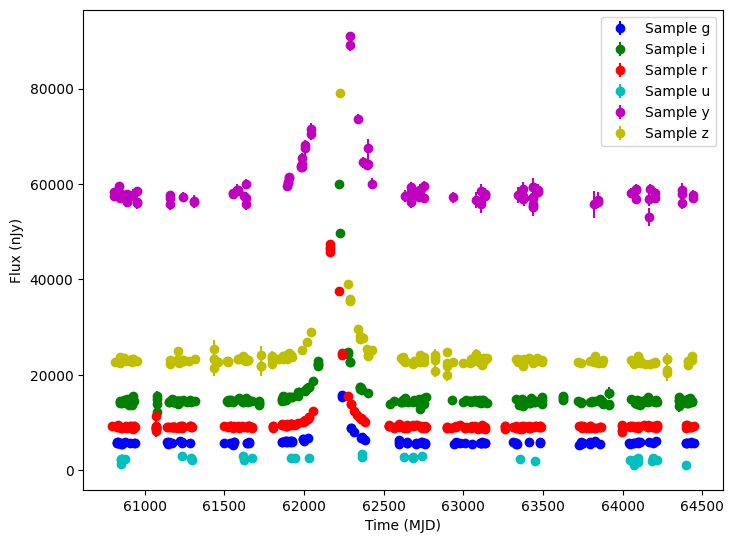

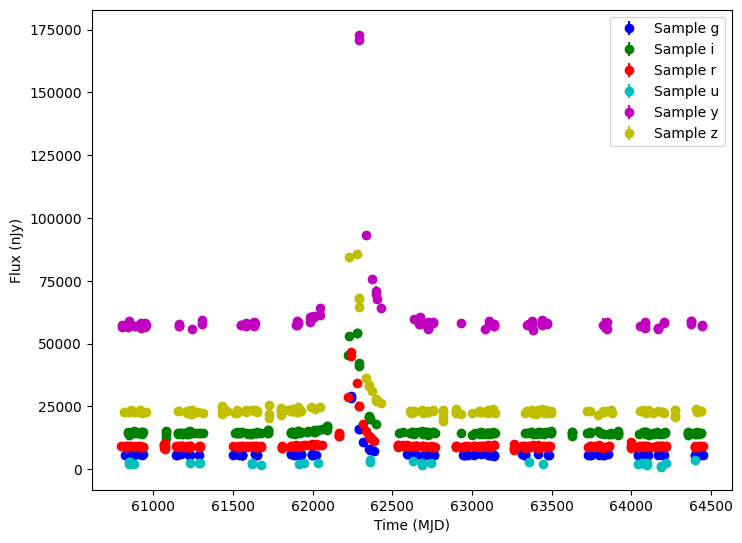

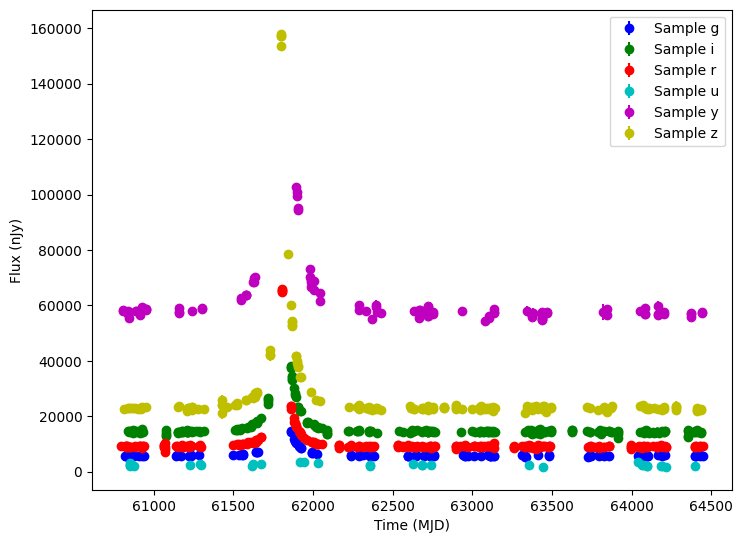

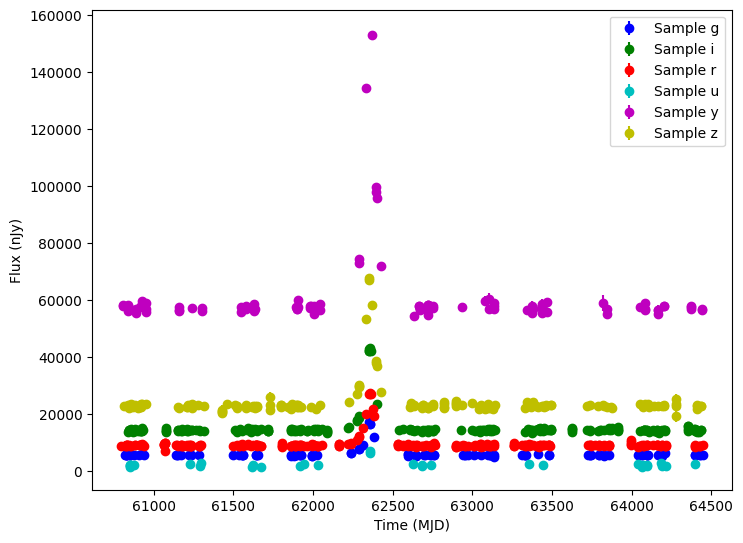

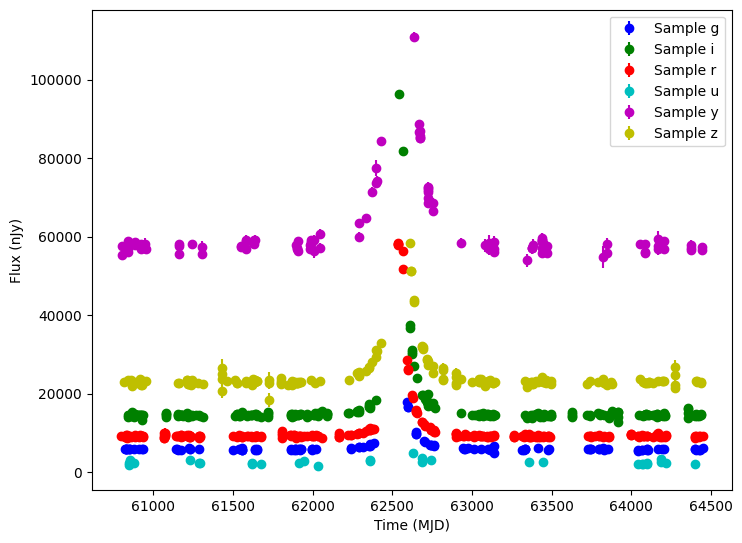

In [10]:
lightcurves = simulate_lightcurves(source2, 5, opsim_db, passband_group)

for idx in range(5):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=np.asarray(lc["lightcurve"]["flux"], dtype=float),
        times=np.asarray(lc["lightcurve"]["mjd"], dtype=float),
        fluxerrs=np.asarray(lc["lightcurve"]["fluxerr"], dtype=float),
        filters=np.asarray(lc["lightcurve"]["filter"], dtype=str),
    )
    ax.legend()
    plt.show()

## Conclusion

This notebook shows how we can create a basic wrapper for the bagle models. A full featured version can be found in ``models/bagle_models.py``, including:
* The ability to set a custom filter map.
* Conditional imports for the bagle package.
* Various helper functions.